# Bayesian Inference for Healthcare Decision Making
### [Team 3: Marta Espejo Fernandez, Josep Soler Perlacia, Jordi Nadeu Ferran]

* Apply Bayesian inference to model patient data and make predictions on disease progression or treatment outcomes, incorporating prior knowledge on a standard dataset.


## Early stage diabetes risk prediction dataset

#### Environment setup

In [7]:
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.estimators import BayesianEstimator
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
# Check if kagglehub is installed
try:
    import kagglehub
except ImportError:
    %pip install kagglehub

# Download latest version
path = kagglehub.dataset_download("yasserhessein/early-stage-diabetes-risk-prediction-dataset")

# print("Path to dataset files:", path)

df = pd.read_csv(path + "/diabetes_data_upload.csv")
df.rename(columns={'class': 'diabetes'}, inplace=True)
df.drop(columns=['Genital thrush', 'partial paresis', 'muscle stiffness'], inplace=True) # Alopecia

# Polyuria: mear mucho
# Polydipsia: beber mucho
# Polyphagia: comer mucho
# delayed healing: mucha azucar en la sangre dificulta la cicatrización

print(df.dtypes)
# print(data.info())
df.head()

Age                    int64
Gender                object
Polyuria              object
Polydipsia            object
sudden weight loss    object
weakness              object
Polyphagia            object
visual blurring       object
Itching               object
Irritability          object
delayed healing       object
Alopecia              object
Obesity               object
diabetes              object
dtype: object


,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,visual blurring,Itching,Irritability,delayed healing,Alopecia,Obesity,diabetes
0,40,Male,No,Yes,No,Yes,No,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,Yes,No,No,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,No,Yes,No,Yes,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


#### Discretize with strictly increasing numeric bin edges

In [8]:
# Age: <30, 30–50, >50
max_age = df['Age'].max()
df['Age'] = pd.cut(
    df['Age'],
    bins=[0, 20, 30, 40, 50, 60, 70, 80, max_age + 1],
    labels=['<20','21-30','31-40','41-50','51-60','61-70','71-80','>80']
)

df.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,visual blurring,Itching,Irritability,delayed healing,Alopecia,Obesity,diabetes
0,31-40,Male,No,Yes,No,Yes,No,No,Yes,No,Yes,Yes,Yes,Positive
1,51-60,Male,No,No,No,Yes,No,Yes,No,No,No,Yes,No,Positive
2,41-50,Male,Yes,No,No,Yes,Yes,No,Yes,No,Yes,Yes,No,Positive
3,41-50,Male,No,No,Yes,Yes,Yes,No,Yes,No,Yes,No,No,Positive
4,51-60,Male,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


## Creating a Bayesian Network:

In this section, we will construct a Bayesian Network by defining its Directed Acyclic Graph (DAG), fitting the Conditional Probability Tables (CPTs) using the dataset, and performing inference to predict diabetes risk based on observed symptoms and attributes.

#### DAG definition

In [9]:
# Define the discrete BN structure

model = DiscreteBayesianNetwork([
    ('Age', 'diabetes'), # Age -> diabetes

    ('Age', 'Alopecia'),
    ('Alopecia', 'diabetes'), # Age -> Alopecia -> diabetes

    ('Gender', 'diabetes'), # Gender -> diabetes

    ('Gender', 'Alopecia'),
    ('Alopecia', 'diabetes'), # Gender -> Alopecia -> diabetes

    ('Itching', 'Irritability'),
    ('Irritability', 'diabetes'), # Itching -> Irritability -> diabetes

    ('Obesity', 'diabetes'), # Obesity -> diabetes

    ('Polyuria', 'Polydipsia'),
    ('Polydipsia', 'diabetes'), # Polyuria -> Polydipsia -> diabetes

    ('Polyuria', 'Polydipsia'),
    ('Polydipsia', 'Polyphagia'),
    ('Polyphagia', 'diabetes'), # Polyuria -> Polydipsia -> Polyphagia -> diabetes

    ('Polydipsia', 'sudden weight loss'),
    ('sudden weight loss', 'diabetes'), # Polydipsia -> sudden weight loss -> diabetes

    ('sudden weight loss', 'weakness'),
    ('weakness', 'diabetes'), # sudden weight loss -> weakness -> diabetes

    ('delayed healing', 'diabetes'), # delayed healing -> diabetes

    ('weakness', 'visual blurring'),
    ('visual blurring', 'diabetes') # weakness -> visual blurring -> diabetes
])

#### CPTs Fitting

In [10]:
# Create a copy of the DataFrame to avoid modifying the original data
df_encoded = df.copy()
# Drop rows with NaN values
df_encoded.dropna(inplace=True)
# Convert all columns to string type for consistency
df_encoded = df_encoded.astype(str)
# Fit the model using Bayesian Estimator
model.fit(
    data=df_encoded.astype(str),
    estimator=BayesianEstimator,
    prior_type='BDeu'
)

In [11]:
# Print out the learned CPTs
print("Nodes:", model.nodes())
print("Edges:", model.edges())

print("CPDs:")
for cpd in model.get_cpds():
    print(cpd, '\n')

Nodes: ['Age', 'diabetes', 'Alopecia', 'Gender', 'Itching', 'Irritability', 'Obesity', 'Polyuria', 'Polydipsia', 'Polyphagia', 'sudden weight loss', 'weakness', 'delayed healing', 'visual blurring']
Edges: [('Age', 'diabetes'), ('Age', 'Alopecia'), ('Alopecia', 'diabetes'), ('Gender', 'diabetes'), ('Gender', 'Alopecia'), ('Itching', 'Irritability'), ('Irritability', 'diabetes'), ('Obesity', 'diabetes'), ('Polyuria', 'Polydipsia'), ('Polydipsia', 'diabetes'), ('Polydipsia', 'Polyphagia'), ('Polydipsia', 'sudden weight loss'), ('Polyphagia', 'diabetes'), ('sudden weight loss', 'diabetes'), ('sudden weight loss', 'weakness'), ('weakness', 'diabetes'), ('weakness', 'visual blurring'), ('delayed healing', 'diabetes'), ('visual blurring', 'diabetes')]
CPDs:
+------------+------------+
| Age(21-30) | 0.085      |
+------------+------------+
| Age(31-40) | 0.235476   |
+------------+------------+
| Age(41-50) | 0.277381   |
+------------+------------+
| Age(51-60) | 0.243095   |
+------------+

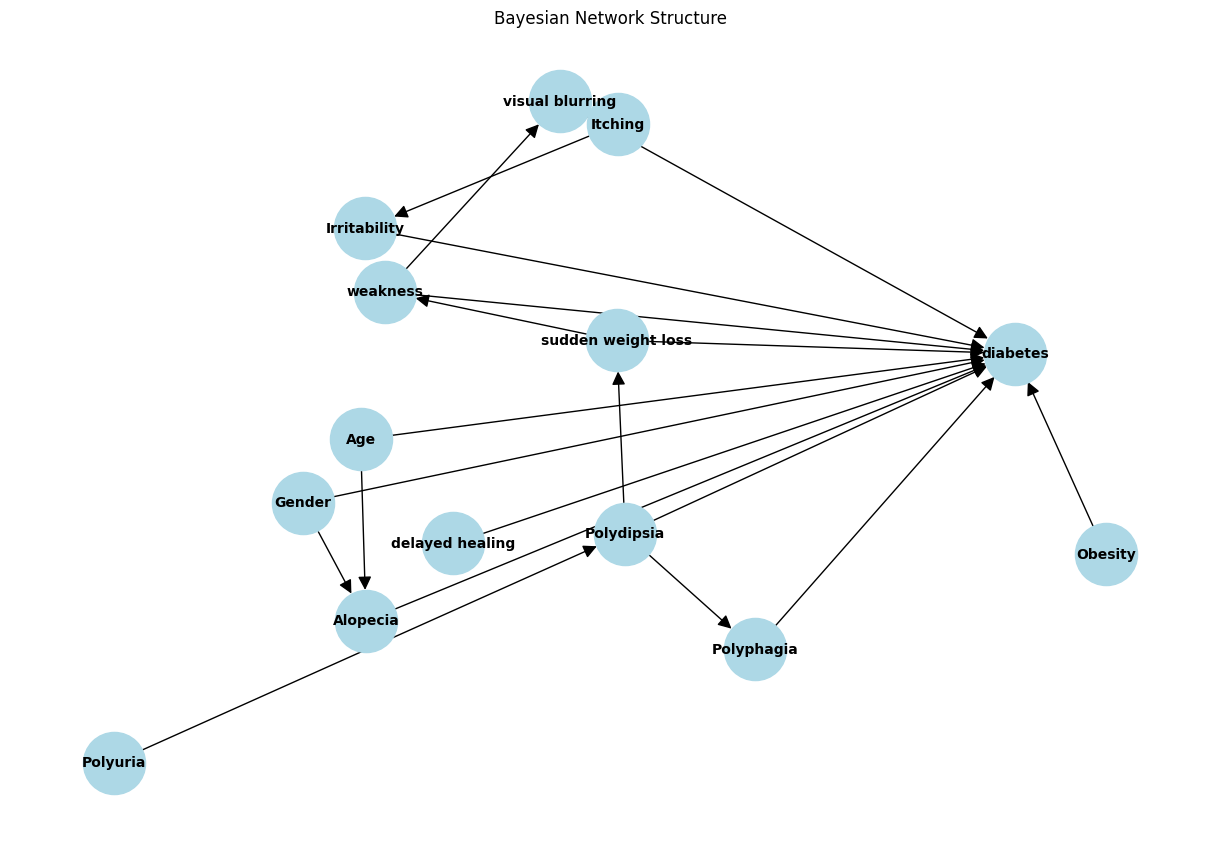

In [12]:
# Recreate the graph from the model's edges
G = nx.DiGraph()
G.add_edges_from(model.edges())

# Use a stable layout
pos = nx.spring_layout(G, seed=42)

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(
    G, pos,
    with_labels=True,
    node_size=2000,
    node_color='lightblue',
    font_size=10,
    font_color='black',
    font_weight='bold',
    arrows=True,
    arrowstyle='-|>',
    arrowsize=20
)
plt.title("Bayesian Network Structure")
plt.show()

####  Inference Queries

##### Bayesian Network

In [20]:
# Create inference object
infer = VariableElimination(model)

# Query: P(diabetes | Gender=Female, Alopecia=Yes)
posterior = infer.query(
    variables=['diabetes'],
    evidence={'Gender': 'Female', 'Alopecia':'Yes'}
)

# Print the resulting posterior distribution
print("Exact inference result for P(diabetes | Gender=Female, Alopecia=Yes):")
print(posterior)

example_query_1 = infer.query(
    variables=['diabetes'],
    evidence={'Polydipsia': 'Yes', 'Polyphagia': 'Yes'}
)
bn_confidence_1 = example_query_1.values[1]

print(f"Bayesian Network inference: P(diabetes=Yes | Polydipsia=Yes, Polyphagia=Yes) = {bn_confidence_1:.2f}")

example_query_2 = infer.query(
    variables=['diabetes'],
    evidence={'Polydipsia': 'Yes', 'sudden weight loss': 'Yes', 'weakness': 'Yes'}
)
bn_confidence_2 = example_query_2.values[1]

print(f"Bayesian Network inference: P(diabetes=Yes | Polydipsia=Yes, sudden weight loss=Yes, weakness=Yes) = {bn_confidence_2:.2f}")

Exact inference result for P(diabetes | Gender=Female, Alopecia=Yes):
+--------------------+-----------------+
| diabetes           |   phi(diabetes) |
+====================+=================+
| diabetes(Negative) |          0.5104 |
+--------------------+-----------------+
| diabetes(Positive) |          0.4896 |
+--------------------+-----------------+
Bayesian Network inference: P(diabetes=Yes | Polydipsia=Yes, Polyphagia=Yes) = 0.57
Bayesian Network inference: P(diabetes=Yes | Polydipsia=Yes, sudden weight loss=Yes, weakness=Yes) = 0.59


##### Gaussian Naive Bayes

In [21]:
from sklearn.preprocessing import LabelEncoder

# Work from the original df (not df_encoded)
df_ml = df.copy()

# Map target variable
df_ml['diabetes'] = df_ml['diabetes'].map({'Positive': 'Yes', 'Negative': 'No'})

# Encode all categorical features using LabelEncoder
le = LabelEncoder()
for col in df_ml.columns:
    if df_ml[col].dtype == 'object' or isinstance(df_ml[col].dtype, pd.CategoricalDtype):
        df_ml[col] = le.fit_transform(df_ml[col].astype(str))


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

X = df_ml.drop(columns=['diabetes'])
y = df_ml['diabetes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_accuracy = gnb.score(X_test, y_test)
gnb_confidence = gnb.predict_proba(X_test)[:, 1].mean()

print(f"Gaussian Naive Bayes Accuracy: {gnb_accuracy:.2f}")
print(f"Average confidence (P(diabetes=Yes)) from GaussianNB: {gnb_confidence:.2f}")



Gaussian Naive Bayes Accuracy: 0.88
Average confidence (P(diabetes=Yes)) from GaussianNB: 0.67


In [23]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)

example_query_1 = infer.query(
    variables=['diabetes'],
    evidence={'Polydipsia': 'Yes', 'Polyphagia': 'Yes'}
)
bn_confidence_1 = example_query_1.values[1]

print(f"Bayesian Network inference: P(diabetes=Yes | Polydipsia=Yes, Polyphagia=Yes) = {bn_confidence_1:.2f}")

example_query_2 = infer.query(
    variables=['diabetes'],
    evidence={'Polydipsia': 'Yes', 'sudden weight loss': 'Yes', 'weakness': 'Yes'}
)
bn_confidence_2 = example_query_2.values[1]

print(f"Bayesian Network inference: P(diabetes=Yes | Polydipsia=Yes, sudden weight loss=Yes, weakness=Yes) = {bn_confidence_2:.2f}")

example_query = infer.query(
    variables=['diabetes']
)
bn_confidence = example_query_1.values[1]

print(f"Bayesian Network inference: P(diabetes=Yes) = {bn_confidence:.2f}")

Bayesian Network inference: P(diabetes=Yes | Polydipsia=Yes, Polyphagia=Yes) = 0.57
Bayesian Network inference: P(diabetes=Yes | Polydipsia=Yes, sudden weight loss=Yes, weakness=Yes) = 0.59
Bayesian Network inference: P(diabetes=Yes) = 0.57


#### Compare the results

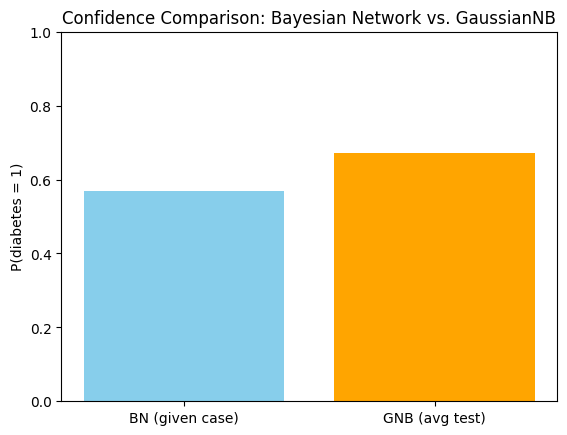

In [17]:
import matplotlib.pyplot as plt

plt.bar(['BN (given case)', 'GNB (avg test)'], [bn_confidence, gnb_confidence], color=['skyblue', 'orange'])
plt.ylabel("P(diabetes = 1)")
plt.title("Confidence Comparison: Bayesian Network vs. GaussianNB")
plt.ylim(0, 1)
plt.show()


### Multiple Confidence comparison

##### Running the inference with BN and GNB for each defined case

##### Results

In [18]:
results = []
exemp = [1, 6, 58, 77, 85, 89]

for i in exemp: # range(len(X_test))
    sample = X_test.iloc[i]
    evidence_dict = sample.to_dict()

    # Fixed evidence extraction logic
    evidence = {}

    for key, val in evidence_dict.items():
        if isinstance(val, (int, float)) and val in [0, 1]:
            try:
                if '_' in key:
                    parts = key.split('_')
                    if len(parts) >= 2 and val == 1:
                        feat = parts[0]
                        states = model.get_cpds(feat).state_names[feat]
                        evidence[feat] = parts[1] if parts[1] in states else None
                else:
                    states = model.get_cpds(key).state_names[key]
                    mapped_val = states[int(val)]  # 0 or 1 → 'No' or 'Yes'
                    evidence[key] = mapped_val
            except:
                continue  # Skip anything not in the model

    try:
        bn_result = infer.query(variables=['diabetes'], evidence=evidence)
        bn_conf = bn_result.values[1]
    except:
        bn_conf = float('nan')

    gnb_conf = gnb.predict_proba([sample])[0][1]

    results.append({
        'Evidence': evidence,
        'BN_P(diabetes=1)': bn_conf,
        'GNB_P(diabetes=1)': gnb_conf
    })
    # print(f"{i} -- BN = {bn_conf:.3f} | GNB = {gnb_conf:.3f}")

# Display results in a DataFrame
import pandas as pd
pd.set_option('display.max_colwidth', None)

df_results = pd.DataFrame(results)
print(df_results)



                                                                                                                                                                                                                                                                        Evidence  \
0  {'Age': '31-40', 'Gender': 'Female', 'Polyuria': 'Yes', 'Polydipsia': 'Yes', 'sudden weight loss': 'No', 'weakness': 'Yes', 'Polyphagia': 'Yes', 'visual blurring': 'No', 'Itching': 'Yes', 'Irritability': 'No', 'delayed healing': 'No', 'Alopecia': 'No', 'Obesity': 'No'}   
1      {'Age': '21-30', 'Gender': 'Female', 'Polyuria': 'No', 'Polydipsia': 'No', 'sudden weight loss': 'No', 'weakness': 'No', 'Polyphagia': 'No', 'visual blurring': 'Yes', 'Itching': 'No', 'Irritability': 'No', 'delayed healing': 'No', 'Alopecia': 'No', 'Obesity': 'No'}   
2                   {'Gender': 'Male', 'Polyuria': 'Yes', 'Polydipsia': 'No', 'sudden weight loss': 'No', 'weakness': 'Yes', 'Polyphagia': 'Yes', 'visual blurring': 'No', '

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:27

Age=31-40, Gender=Female, Polyuria=Yes, Polydipsia=Yes, sudden weight loss=No, weakness=Yes, Polyphagia=Yes, visual blurring=No, Itching=Yes, Irritability=No, delayed healing=No, Alopecia=No, Obesity=No


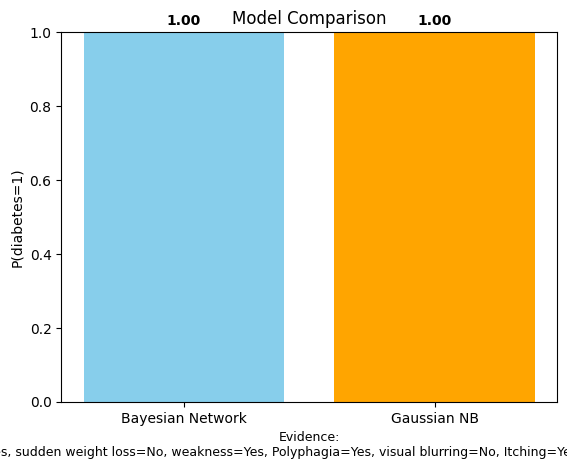

Age=21-30, Gender=Female, Polyuria=No, Polydipsia=No, sudden weight loss=No, weakness=No, Polyphagia=No, visual blurring=Yes, Itching=No, Irritability=No, delayed healing=No, Alopecia=No, Obesity=No


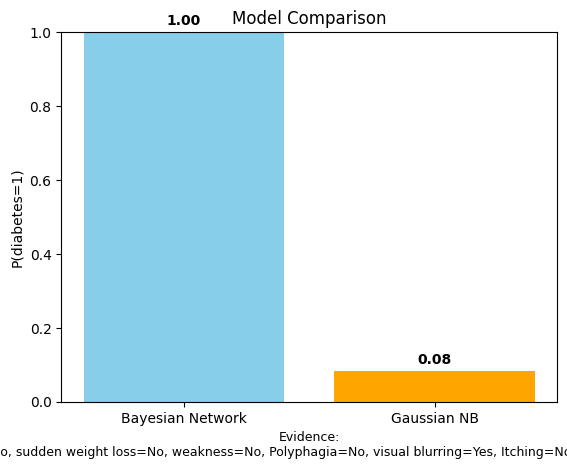

Gender=Male, Polyuria=Yes, Polydipsia=No, sudden weight loss=No, weakness=Yes, Polyphagia=Yes, visual blurring=No, Itching=Yes, Irritability=No, delayed healing=Yes, Alopecia=Yes, Obesity=No


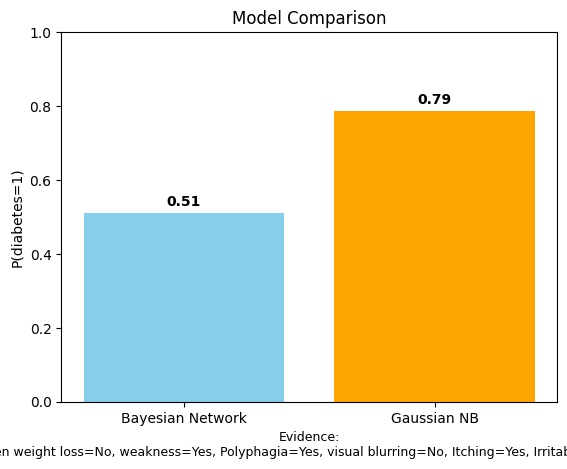

Gender=Male, Polyuria=No, Polydipsia=No, sudden weight loss=No, weakness=Yes, Polyphagia=No, visual blurring=No, Itching=Yes, Irritability=No, delayed healing=Yes, Alopecia=Yes, Obesity=No


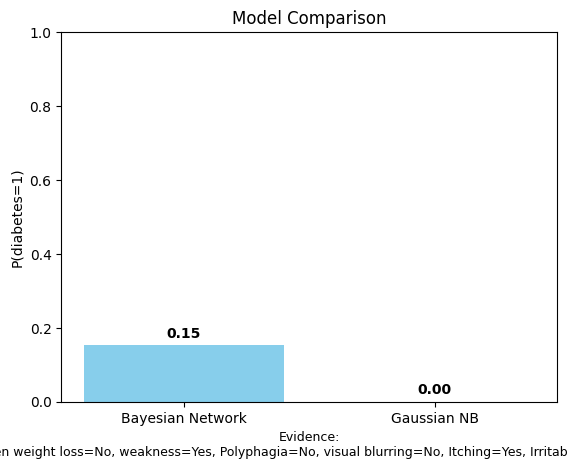

Age=31-40, Gender=Male, Polyuria=Yes, Polydipsia=No, sudden weight loss=Yes, weakness=Yes, Polyphagia=No, visual blurring=No, Itching=No, Irritability=No, delayed healing=No, Alopecia=No, Obesity=No


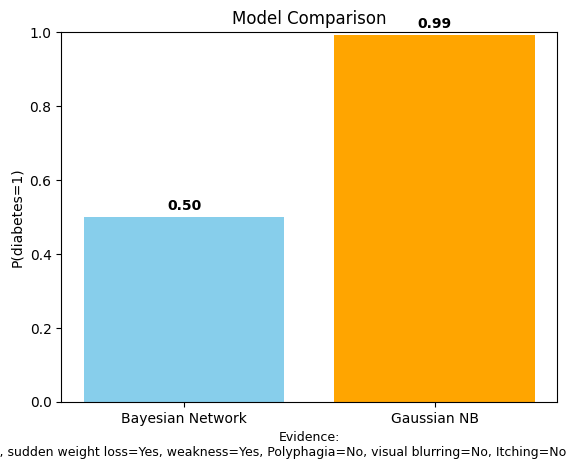

Gender=Female, Polyuria=Yes, Polydipsia=Yes, sudden weight loss=Yes, weakness=Yes, Polyphagia=Yes, visual blurring=Yes, Itching=Yes, Irritability=No, delayed healing=Yes, Alopecia=No, Obesity=Yes


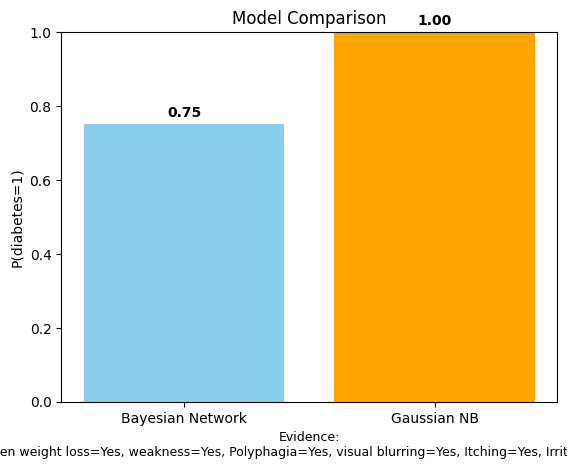

In [19]:
import matplotlib.pyplot as plt

# Fill NaN values with 0.0 for plotting
df_results_filled = df_results.fillna(0.0)

for idx, row in df_results_filled.iterrows():
    bn_val = row['BN_P(diabetes=1)']
    gnb_val = row['GNB_P(diabetes=1)']

    labels = ['Bayesian Network', 'Gaussian NB']
    values = [bn_val, gnb_val]

    evidence_dict = row['Evidence']
    evidence_str = ", ".join([f"{k}={v}" for k, v in evidence_dict.items()])
    print(evidence_str)

    plt.bar(labels, values, color=['skyblue', 'orange'])
    plt.title("Model Comparison")
    plt.xlabel(f"Evidence:\n{evidence_str}", fontsize=9)

    plt.ylabel("P(diabetes=1)")
    plt.ylim(0, 1)

    for i, v in enumerate(values):
        plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')

    plt.show()


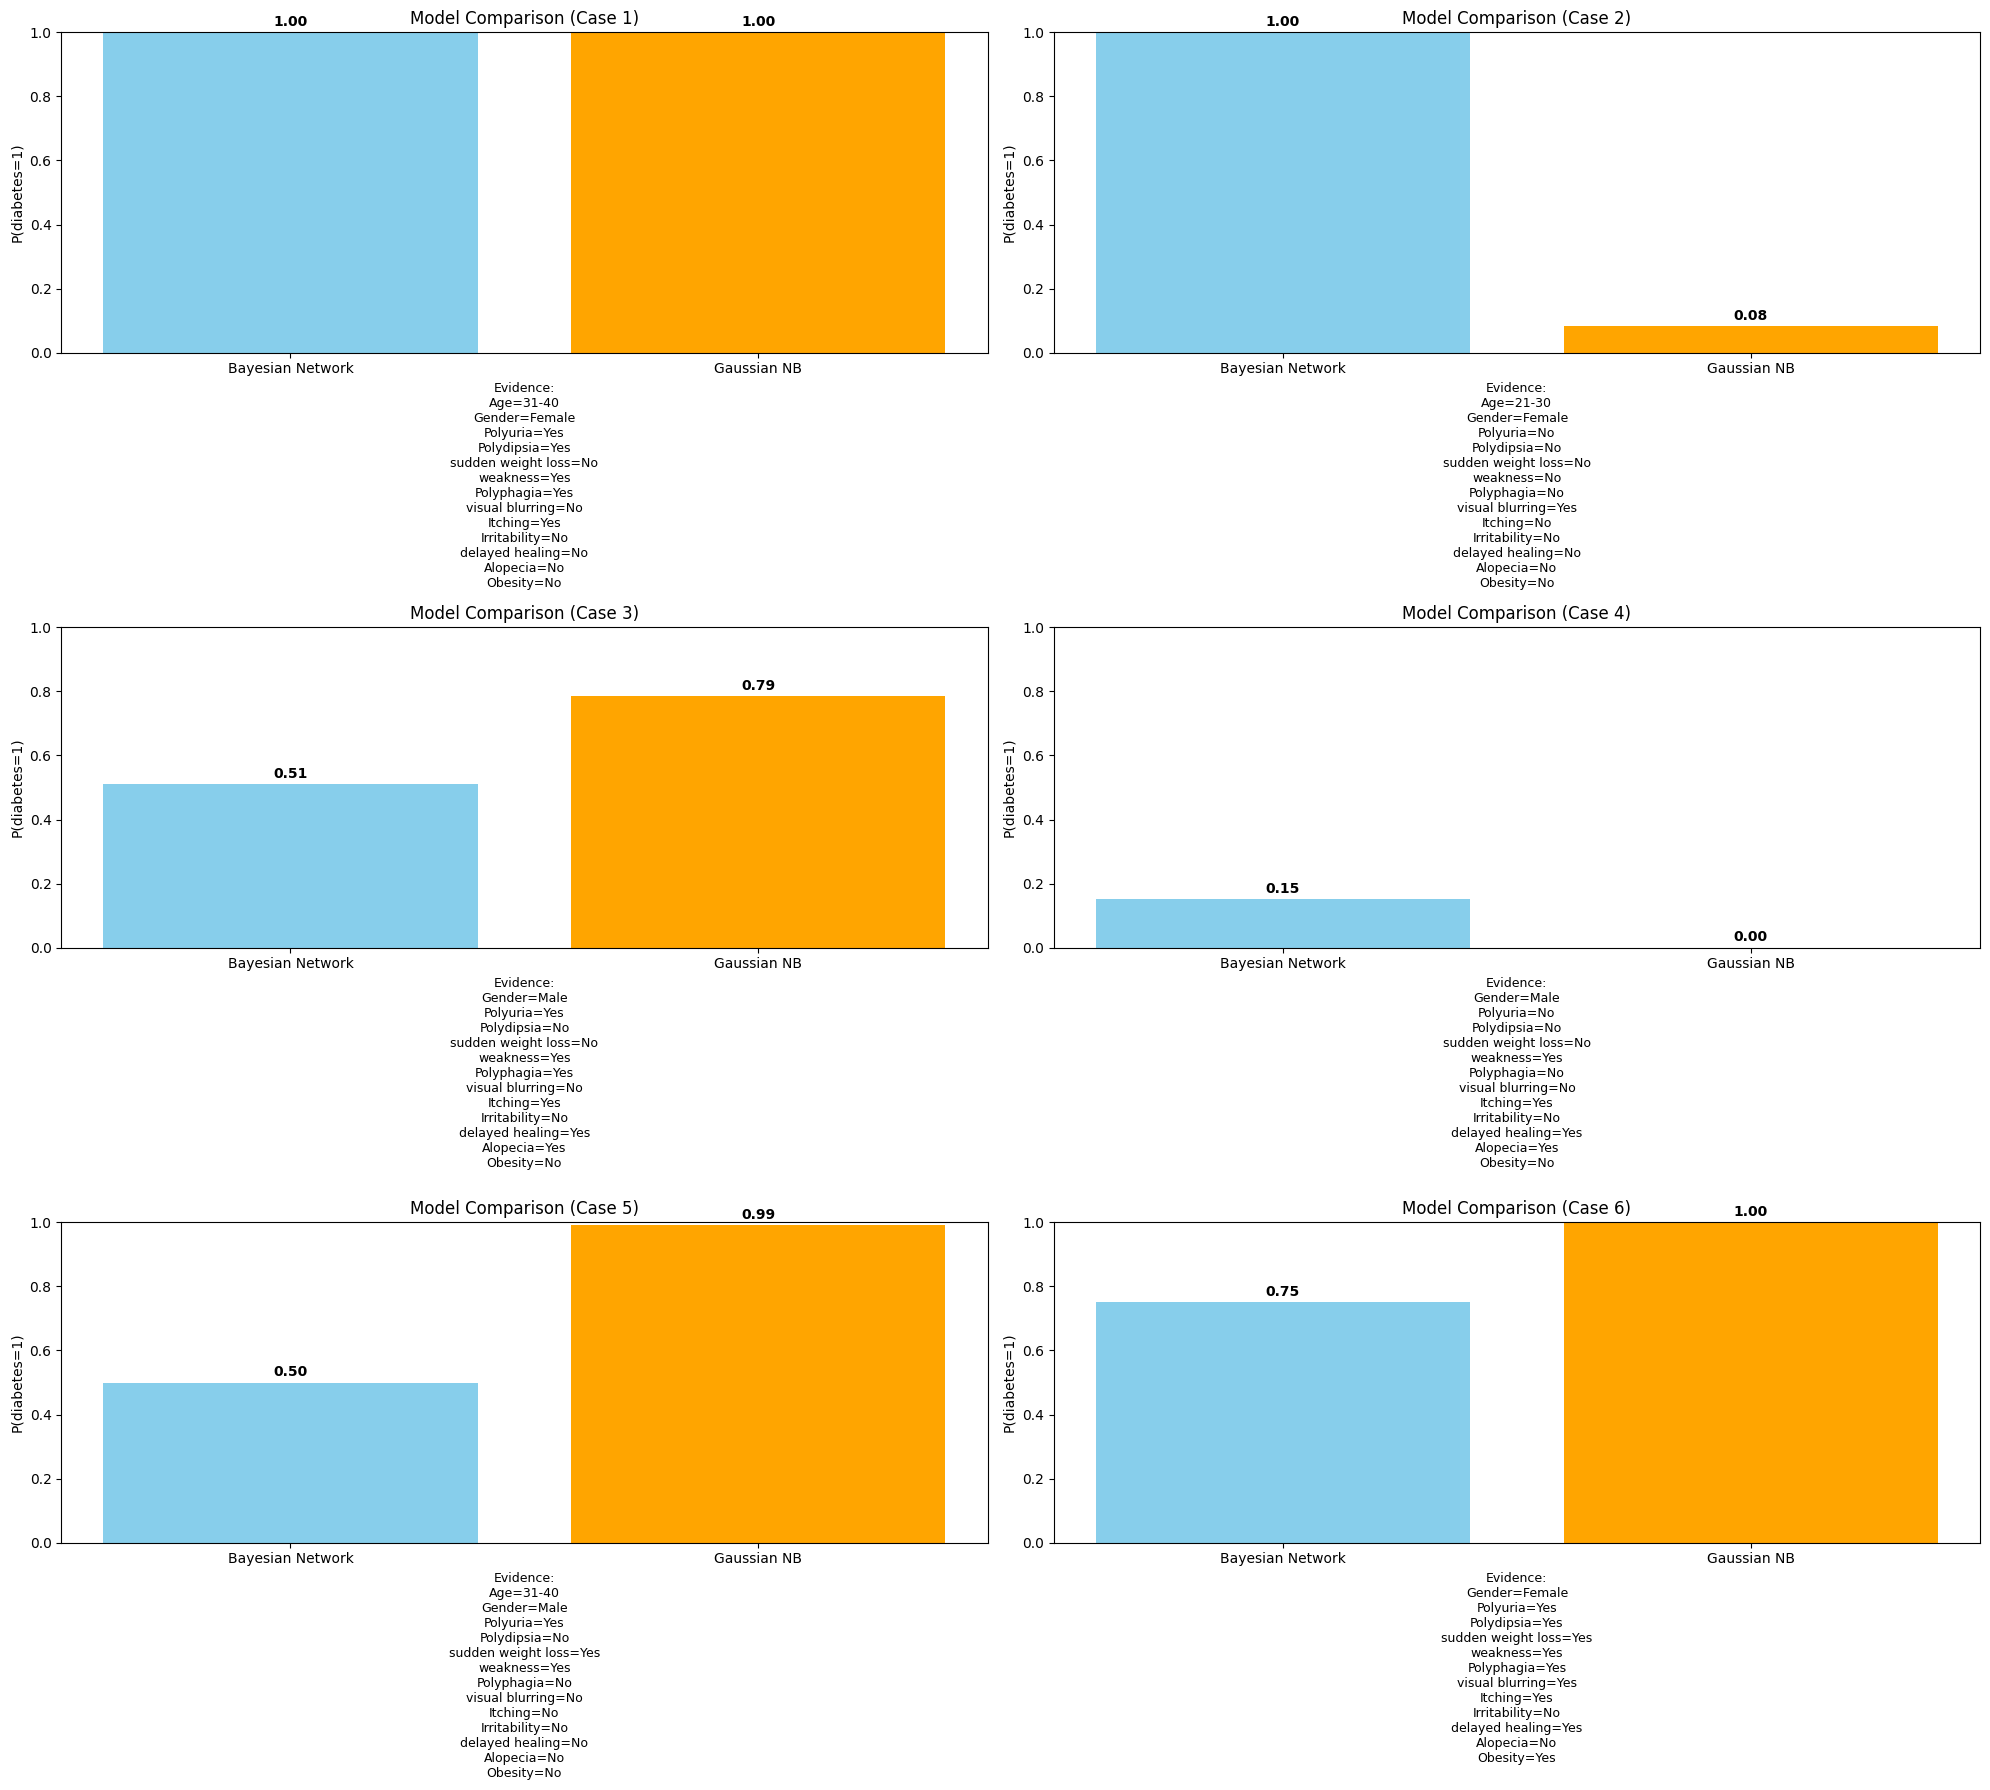

In [26]:
import matplotlib.pyplot as plt
# Fill NaN values with 0.0 for plotting
df_results_filled = df_results.fillna(0.0)

# Determine the number of subplots needed
num_plots = len(df_results_filled)
# Calculate the number of rows and columns for the subplots
n_cols = 2 # You can adjust the number of columns as needed
n_rows = (num_plots + n_cols - 1) // n_cols # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10 * n_cols, 6 * n_rows))
# Flatten the axes array if it's 2D to easily iterate
if n_rows > 1 or n_cols > 1:
    axes = axes.flatten()
else:
    axes = [axes] # Make it an iterable list even if there's only one subplot

for idx, row in df_results_filled.iterrows():
    ax = axes[idx] # Select the current subplot axis

    bn_val = row['BN_P(diabetes=1)']
    gnb_val = row['GNB_P(diabetes=1)']

    labels = ['Bayesian Network', 'Gaussian NB']
    values = [bn_val, gnb_val]

    evidence_dict = row['Evidence']
    # Format the evidence string to break into multiple lines
    evidence_items = [f"{k}={v}" for k, v in evidence_dict.items()]
    evidence_str = "\n".join(["\n".join(evidence_items[i:i+3]) for i in range(0, len(evidence_items), 3)])


    ax.bar(labels, values, color=['skyblue', 'orange'])
    ax.set_title(f"Model Comparison (Case {idx+1})")
    ax.set_xlabel(f"Evidence:\n{evidence_str}", fontsize=9)
    ax.set_ylabel("P(diabetes=1)")
    ax.set_ylim(0, 1)

    for i, v in enumerate(values):
        ax.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')

# Hide any unused subplots
for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()
